# Installation de Pypsark

In [1]:
!pip install pyspark

# Prérequis

In [202]:
# Libraries classiques
import numpy as np
import pandas as pd
import statistics
from random import *
import datetime

# Affichage
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Prétraitement
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing

# Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Librairies Spark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import findspark
findspark.init()

In [121]:
# Initiation de SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

# I. Analyse et prétraitement

In [254]:
data = spark.read.csv('./Data/deceased.csv',
                      inferSchema=True,
                      header=True)

print('\n--- Columns ---\n')
print(data)

print('\n--- Data ---\n')
data.show()

print('\n--- Schema ---\n')
data.printSchema()

print('\n--- Pandas Dataframe ---\n')
df = data.toPandas()
print(df)

print('\n--- Description ---\n')
data.describe().show()


--- Columns ---

DataFrame[sex: string, birth_year: int, country: string, region: string, departement: string, city: string, group: string, infection_reason: string, confirmed_date: string, deceased_date: string, source: string, comments: string]

--- Data ---

+------+----------+-------+--------------------+------------+--------------------+---------------+--------------------+--------------+-------------+--------------------+--------------------+
|   sex|birth_year|country|              region| departement|                city|          group|    infection_reason|confirmed_date|deceased_date|              source|            comments|
+------+----------+-------+--------------------+------------+--------------------+---------------+--------------------+--------------+-------------+--------------------+--------------------+
|  male|      1957| France|     Hauts-de-France|       Aisne|                null|Crépy-en-Valois|contact with patient|    2020-02-29|   2020-03-05|CP Préfecture Ha

+-------+------+------------------+-------+--------------------+-----------+--------+---------------+--------------------+--------------+-------------+--------------------+----------------+
|summary|   sex|        birth_year|country|              region|departement|    city|          group|    infection_reason|confirmed_date|deceased_date|              source|        comments|
+-------+------+------------------+-------+--------------------+-----------+--------+---------------+--------------------+--------------+-------------+--------------------+----------------+
|  count|    35|                38|     51|                  51|         48|      17|              8|                   4|            17|           51|                  42|              23|
|   mean|  null|1938.6842105263158|   null|                null|       null|    null|           null|                null|          null|         null|                null|            null|
| stddev|  null|10.659611227528362|   null|       

In [255]:
# Suppression de variables non pertinentes à notre étude

data = data.drop('country', # nous travaillons sur des données francaises
                'source',
                'comments')

df.drop('country', axis=1, inplace=True)
df.drop('source', axis=1, inplace=True)
df.drop('comments', axis=1, inplace=True)

data = data.na.drop(how="all")

In [256]:
# On remplace le valeurs vides par le mode de la variable concernée 

data.groupby('sex').count().show()
data = data.na.fill("Male",["sex"])

data.groupby('city').count().show()
data = data.na.fill("Crépy-en-Valois",["city"])

data.groupby('birth_year').count().show()
data = data.na.fill("1934",["birth_year"])

data.groupby('region').count().show()
data = data.na.fill("Hauts-de-France",["region"])

data.groupby('departement').count().show()
data = data.na.fill("Oise",["departement"])

data.groupby('group').count().show()
data = data.na.fill("Crépy-en-Valois",["group"])

data.groupby('infection_reason').count().show()
data = data.na.fill("Dialyse",["infection_reason"])

data.groupby('confirmed_date').count().show()
data = data.na.fill("2020-03-08",["confirmed_date"])

data.groupby('deceased_date').count().show()
data = data.na.fill("2020-03-15",["deceased_date"])

+------+-----+
|   sex|count|
+------+-----+
|Female|    7|
|female|    6|
|  male|   18|
|  Male|    4|
|  null|   16|
+------+-----+

+--------------------+-----+
|                city|count|
+--------------------+-----+
|     Crépy-en-Valois|    4|
|            Vaumoise|    1|
|Saint-Vaast-les-M...|    2|
|       Méry-sur-Oise|    1|
|               Nyons|    1|
|             Mauguio|    1|
|               Creil|    1|
|             Quillan|    1|
|              Crac’h|    1|
|             Ajaccio|    3|
|Nanteuil-le-Haudouin|    1|
|                null|   34|
+--------------------+-----+

+----------+-----+
|birth_year|count|
+----------+-----+
|      1959|    1|
|      1955|    1|
|      1925|    1|
|      1942|    1|
|      1944|    2|
|      1939|    1|
|      1922|    1|
|      1934|    4|
|      1930|    1|
|      1938|    1|
|      1947|    2|
|      1971|    1|
|      1932|    1|
|      1957|    1|
|      1945|    1|
|      1943|    1|
|      1960|    1|
|      1926|    2|


In [257]:
data_df = data.toPandas()

data_df=data_df.assign(Age=data_df["birth_year"])
data_df['Age'].fillna(data_df['Age'].mode()[0],inplace=True)
age = pd.to_datetime(data_df.iloc[0][8]).year - data_df['Age']
data_df['Age'] = age
data_df

data = spark.createDataFrame(data_df)
data.show()

sex                  0
birth_year          13
region               0
departement          0
city                 0
group                0
infection_reason     0
confirmed_date       0
deceased_date        0
Age                  0
dtype: int64
+------+----------+--------------------+------------+--------------------+---------------+--------------------+--------------+-------------+----+
|   sex|birth_year|              region| departement|                city|          group|    infection_reason|confirmed_date|deceased_date| Age|
+------+----------+--------------------+------------+--------------------+---------------+--------------------+--------------+-------------+----+
|  male|    1957.0|     Hauts-de-France|       Aisne|     Crépy-en-Valois|Crépy-en-Valois|contact with patient|    2020-02-29|   2020-03-05|63.0|
|  male|    1943.0|     Hauts-de-France|       Aisne|     Crépy-en-Valois|Crépy-en-Valois|             Dialyse|    2020-03-08|   2020-03-08|77.0|
|  male|    1931.0|        

In [258]:
# Transformation des données textuelles en données numérique via la classe StringIndexer

#columns = ["sex", "departement","region","city","group","infection_reason","confirmed_date","deceased_date"] 
indexers = [StringIndexer(inputCol=column, 
                          outputCol=column+"_index").fit(data).setHandleInvalid("keep") for column in list(set(df.columns)-set(['Age']))]

print(indexers)
pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(data).transform(data)

# On supprime les anciens nom de variables
df_r = df_r.drop('sex',
                 'departement',
                 'birth_year',
                 'birth_year_index',
                 'region',
                 'city',
                 'group',
                 'infection_reason',
                 'confirmed_date',
                 'deceased_date')

# On renomme les nouvelles colonnes obtenues
df_r = df_r.withColumnRenamed('sex_index','Sex')
df_r = df_r.withColumnRenamed('region_index','Region')
df_r = df_r.withColumnRenamed('departement_index','Departement')
df_r = df_r.withColumnRenamed('city_index','City')
df_r = df_r.withColumnRenamed('group_index','Group')
df_r = df_r.withColumnRenamed('infection_reason_index','Infection_reason')
df_r = df_r.withColumnRenamed('confirmed_date_index','Confirmed_date')
df_r = df_r.withColumnRenamed('deceased_date_index','Deceased_date')

print("\n--- Data ---\n")
df_r.show()
print("\n--- Schema ---\n")
df_r.printSchema()
dfPandas = df_r.toPandas()

[StringIndexerModel: uid=StringIndexer_0d2f2a84cea7, handleInvalid=error, StringIndexerModel: uid=StringIndexer_6cd5da77a90a, handleInvalid=error, StringIndexerModel: uid=StringIndexer_1071603fa44c, handleInvalid=error, StringIndexerModel: uid=StringIndexer_21ffcbda335e, handleInvalid=error, StringIndexerModel: uid=StringIndexer_51657cd2a170, handleInvalid=error, StringIndexerModel: uid=StringIndexer_b2eb9a4064e9, handleInvalid=error, StringIndexerModel: uid=StringIndexer_2411e3bd59a3, handleInvalid=error, StringIndexerModel: uid=StringIndexer_35bbb9ba9dfe, handleInvalid=error, StringIndexerModel: uid=StringIndexer_57832a4e9ccb, handleInvalid=error]

--- Data ---

+----+-------------+---+-----------+----------------+----+--------------+------+-----+
| Age|Deceased_date|Sex|Departement|Infection_reason|City|Confirmed_date|Region|Group|
+----+-------------+---+-----------+----------------+----+--------------+------+-----+
|63.0|          6.0|1.0|        3.0|             3.0| 0.0|        

In [259]:
# Normalisation des données

standardScaler = StandardScaler()

model = standardScaler.fit_transform(df_r.toPandas())

df_scaled = pd.DataFrame(model, 
                         columns = ["Region","Sex","Group","Confirmed_date","Departement","Infection_reason","Age","Deceased_date","City"]
                        )
sparkDF=spark.createDataFrame(df_scaled)
sparkDF.show()
sparkDF.printSchema()

+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+
|              Region|                 Sex|               Group|      Confirmed_date|        Departement|    Infection_reason|                Age|       Deceased_date|               City|
+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+
|  -2.096461179154765| 0.47802506435430214|0.019611613513818446| 0.07868178324933274|   5.64550098892288|-0.45987213606717275| 0.4866540181523806| -0.6040742902958346|-0.2917299829957891|
| -0.5920659209472254| 0.20410058927487057|0.019611613513818446| 0.07868178324933274|-0.2304286117927706|-0.45987213606717275|-0.5061201788784757| -0.6040742902958346|-0.2917299829957891|
|  0.6974157289449512| -0.8915973110428557|0.019611613513818

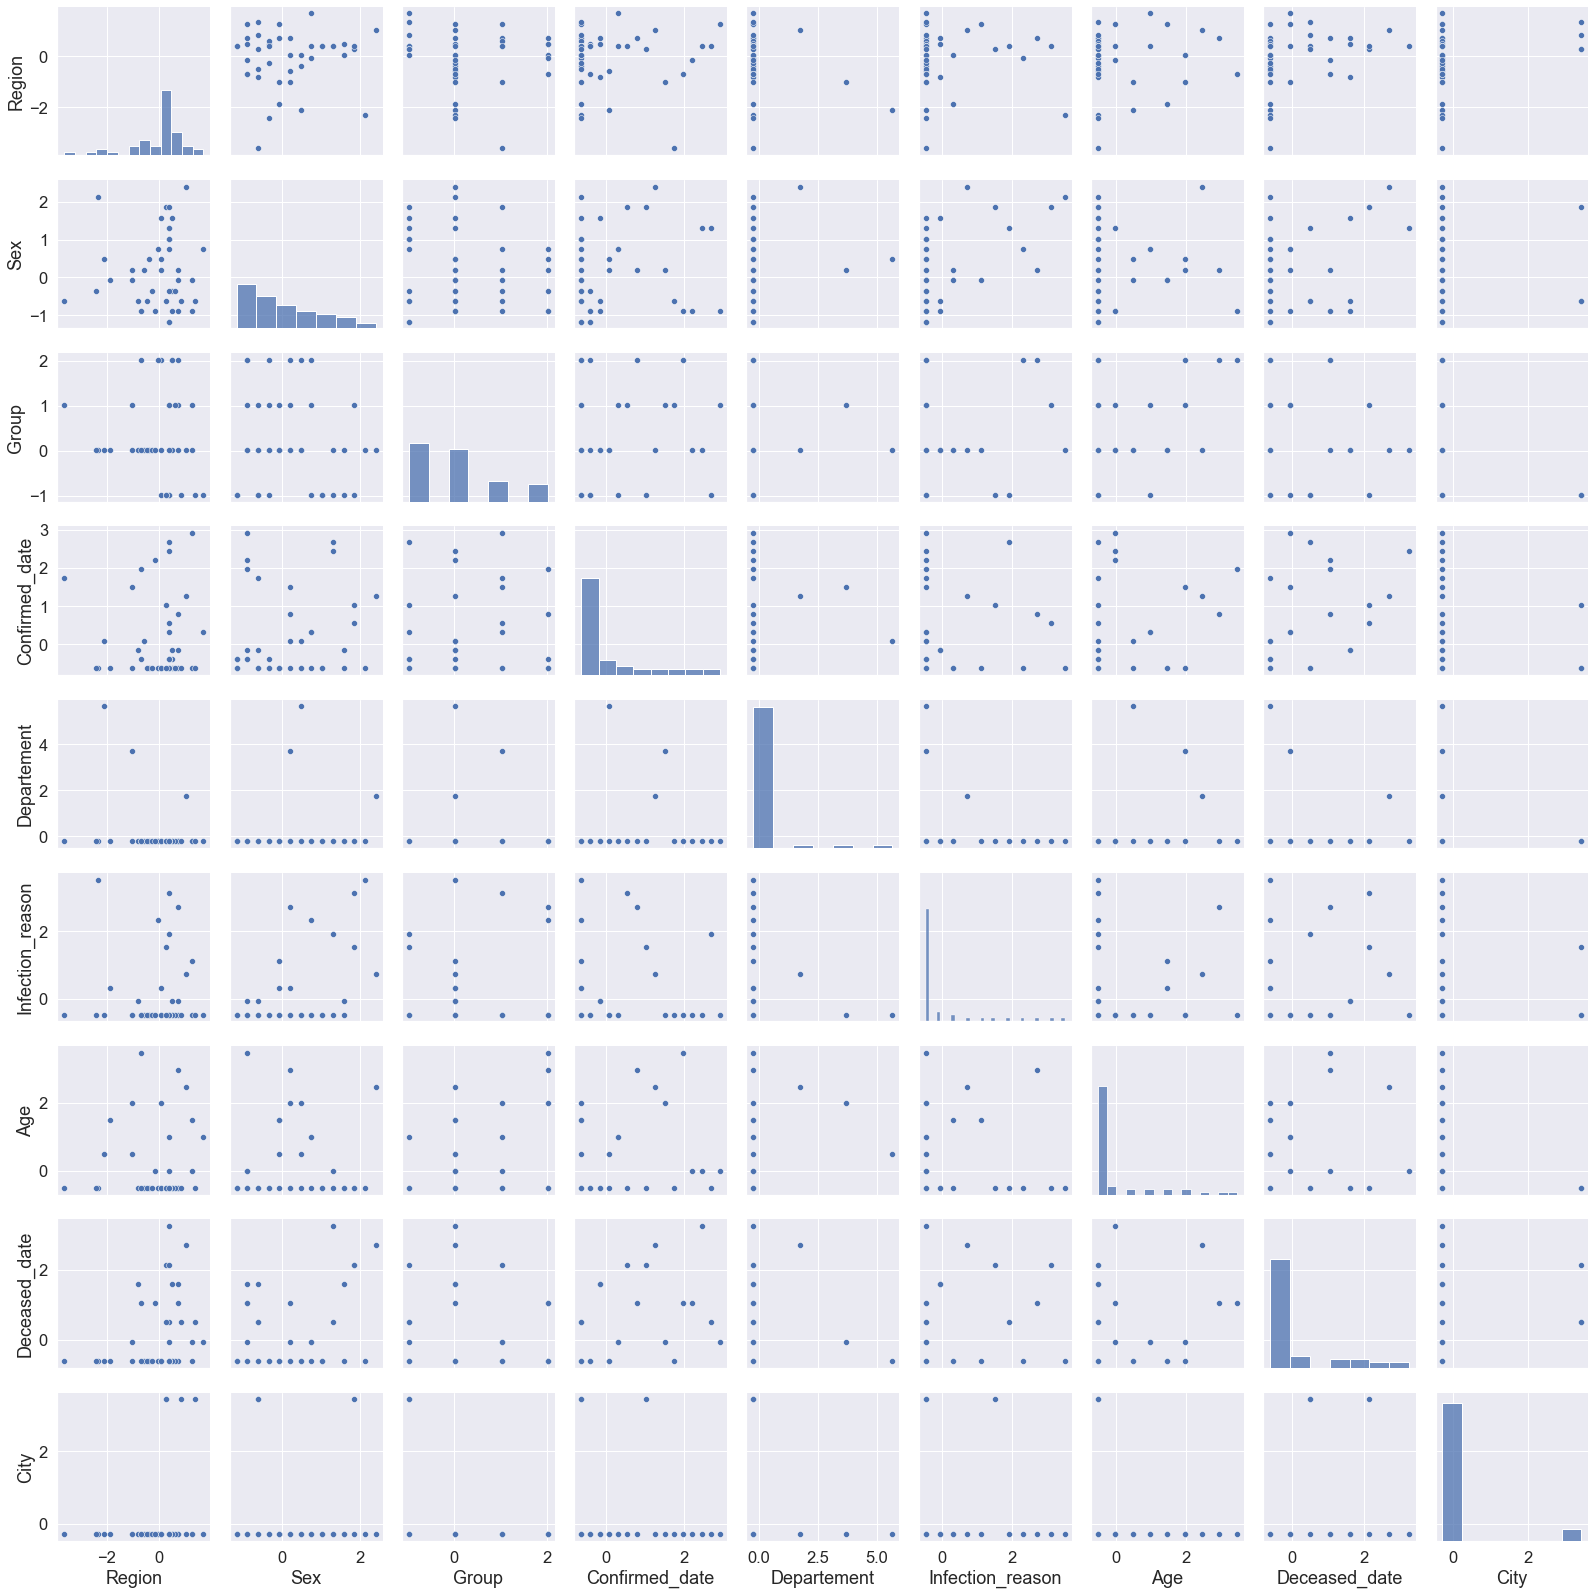

In [260]:
# Calculate and show pairplot

df2 = df_r.toPandas()
sns.pairplot(df_scaled)
plt.tight_layout()

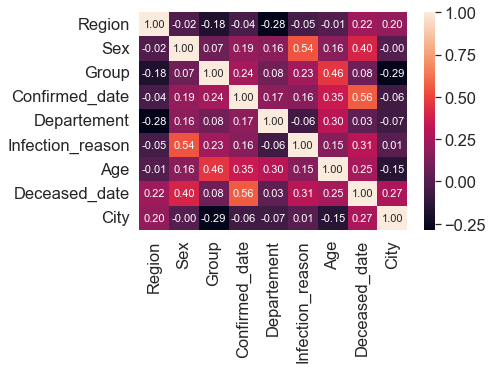

In [261]:
# Matrice de corrélation entre les variables

cm = np.corrcoef(df_scaled.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=False,
                fmt='.2f',
                annot_kws={'size': 11},
                yticklabels=df_scaled.columns,
                xticklabels=df_scaled.columns)

# Departement / Region
# Confirmed_date / Sex
# Confirmed_date / Departement
# Infection_reason / Confirmed_date
# Region / Deceased_date (faible : 0.38)
# Deceased_date / City

In [276]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Region            51 non-null     float64
 1   Sex               51 non-null     float64
 2   Group             51 non-null     float64
 3   Confirmed_date    51 non-null     float64
 4   Departement       51 non-null     float64
 5   Infection_reason  51 non-null     float64
 6   Age               51 non-null     float64
 7   Deceased_date     51 non-null     float64
 8   City              51 non-null     float64
dtypes: float64(9)
memory usage: 3.7 KB



--- ACP Parameters ---
PCA(svd_solver='full')
Components: 9

--- Valeur corrigé ---
[2.4601119  1.717497   1.1724354  1.08640838 0.76514212 0.72417285
 0.41267023 0.38086204 0.28070007]


--- Graphes ---


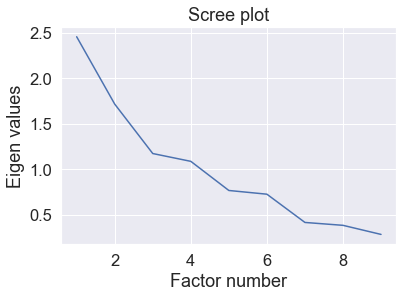

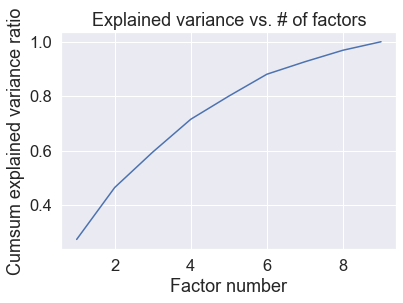

In [263]:
# Instanciation de l'ACP
acp = PCA(svd_solver='full')
print("\n--- ACP Parameters ---")
print(acp)

# Calculs
coord = acp.fit_transform(df_scaled)

# Nombre de composantes calculées
print("Components: " + format(acp.n_components_)) # 9

# Valeur corrigée
eigval = (51-1)/51*acp.explained_variance_
print("\n--- Valeur corrigé ---")
print(eigval)

print("\n\n--- Graphes ---")
plt.plot(np.arange(1,9+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()

plt.plot(np.arange(1,9+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

# II. Apprentissage artificiel

In [264]:
X = dfPandas[["Region","Sex","Group","Confirmed_date","Departement","Infection_reason","Age","City"]].values
y = dfPandas["Deceased_date"].values

In [265]:
X = preprocessing.scale(X)

In [266]:
# Training & testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [267]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [102]:
y_expected = y_test
y_pred = knn.predict(X_test)

print(metrics.classification_report(y_expected,y_pred))

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         1
         4.0       1.00      0.50      0.67         2
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         1
        11.0       0.00      0.00      0.00         1

    accuracy                           0.27        11
   macro avg       0.19      0.17      0.16        11
weighted avg       0.30      0.27      0.27        11



C:\Users\Tom\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tom\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tom\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tom\anaconda3\lib\site-packages\sklearn\metrics\_classificat

In [269]:
assembler = VectorAssembler(inputCols=["Sex", "Departement","Region","City","Group","Infection_reason","Confirmed_date","Age"],
                           outputCol='Attributes')

output = assembler.transform(df_r)
finilized_data = output.select("Attributes","Deceased_date")

print("\n--- Data ---")
finilized_data.show()

X = finilized_data.select('Attributes')
y = finilized_data.select('Deceased_date')


--- Data ---
+--------------------+-------------+
|          Attributes|Deceased_date|
+--------------------+-------------+
|[1.0,3.0,0.0,0.0,...|          6.0|
|(8,[0,1,7],[1.0,3...|          5.0|
|[1.0,2.0,4.0,1.0,...|          1.0|
|[1.0,2.0,4.0,1.0,...|          2.0|
|[1.0,2.0,4.0,1.0,...|         10.0|
|[3.0,6.0,3.0,8.0,...|          5.0|
|(8,[1,2,6,7],[4.0...|          7.0|
|[2.0,4.0,1.0,0.0,...|          7.0|
|[1.0,8.0,6.0,3.0,...|         13.0|
|[2.0,9.0,1.0,0.0,...|          5.0|
|(8,[0,3,7],[1.0,1...|         12.0|
|(8,[0,7],[2.0,89.0])|          4.0|
|(8,[0,6,7],[1.0,2...|          4.0|
|(8,[0,3,6,7],[1.0...|          4.0|
|(8,[0,3,6,7],[1.0...|          4.0|
|(8,[0,7],[1.0,79.0])|          6.0|
|(8,[0,6,7],[3.0,5...|          6.0|
|(8,[0,3,7],[3.0,7...|          7.0|
|(8,[0,3,7],[1.0,2...|          5.0|
|(8,[0,7],[1.0,78.0])|          2.0|
+--------------------+-------------+
only showing top 20 rows



### Train/Test Split 

In [270]:
train_data, test_data = finilized_data.randomSplit([0.8,0.2])

In [275]:
regressor = LinearRegression(featuresCol='Attributes',labelCol='Deceased_date')

# Learn to fit the model from training set
regressor = regressor.fit(train_data)

#To predict the prices on testing set
pred = regressor.evaluate(test_data)

#Predict the model
pred.predictions.show()

C:\Users\Tom\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+-------------+------------------+
|          Attributes|Deceased_date|        prediction|
+--------------------+-------------+------------------+
|(8,[0,3,6,7],[1.0...|          4.0| 3.888560617306613|
|(8,[0,3,7],[1.0,2...|          5.0|  4.21735503271238|
|(8,[0,6,7],[3.0,5...|          6.0|1.4663265543009945|
|(8,[0,7],[1.0,79.0])|          6.0|2.8021043421993994|
|(8,[0,1,7],[2.0,1...|          2.0|1.3209282249173104|
|      (8,[7],[86.0])|          0.0| 3.406192392678876|
|(8,[0,1,7],[1.0,1...|          1.0| 2.709497413725992|
|[0.0,7.0,5.0,5.0,...|         11.0| 6.921714847656489|
+--------------------+-------------+------------------+



In [274]:
# Classification

knn = KNeighborsClassifier(n_neighbors=4)
knn = knn.fit(train_data, test_data)

#To predict the prices on testing set
pred = knn.evaluate(test_data)

#Predict the model
pred.predictions.show()

ValueError: Expected 2D array, got scalar array instead:
array=DataFrame[Attributes: vector, Deceased_date: double].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [244]:
# data.show()

# from pyspark.sql.types import IntegerType,BooleanType,DateType,DoubleType
# data = data.withColumn("sex", data["sex"].cast(DoubleType()))
# data = data.withColumn("region", data["region"].cast(DoubleType()))
# data = data.withColumn("departement", data["departement"].cast(DoubleType()))
# data = data.withColumn("city", data["city"].cast(DoubleType()))
# data = data.withColumn("group", data["group"].cast(DoubleType()))
# data = data.withColumn("infection_reason", data["infection_reason"].cast(DoubleType()))
# data = data.withColumn("confirmed_date", data["confirmed_date"].cast(DoubleType()))
# data = data.withColumn("deceased_date", data["deceased_date"].cast(DoubleType()))
# data.dtypes

In [299]:
# On supprime les colonnes qui semblent inutiles à notre étude
data = data.drop('country', # nous travaillons sur des données francaises
                'source',
                'comments')
data.printSchema()
df.drop('country', axis=1, inplace=True)
df.drop('source', axis=1, inplace=True)
df.drop('comments', axis=1, inplace=True)

#data.select('city').show()

# on rempli les valeurs manquantes (None)

df['sex'].fillna(df['sex'].mode()[0],inplace=True)
#data.withColumn('sex_new',when('sex' == 'male', int(1)).otherwise(int(0)).drop(['sex']).withColumnRenamed('sex_new','Sex').show()
df['sex'] = df['sex'].str.capitalize()
#df['sex'][df['sex']=='Male'] = 0
#df['sex'][df['sex']=='Female'] = 1

df.rename(columns={'birth_year': 'Age'}, inplace=True)
df['Age'].fillna(df['Age'].mode()[0],inplace=True)
print(pd.to_datetime(df.iloc[0][8]).year)
age = pd.to_datetime(df.iloc[0][8]).year - df['Age']
#df['Age'] = age
#print(df2)
df['region'].fillna(df['region'].mode()[0],inplace=True)
df['departement'].fillna(df['departement'].mode()[0],inplace=True)

cities = ['Ajaccio','Ajaccio','Ajaccio',
         'Nyons',
         "Crac'h",
         'Vaumoise',
         'Crépy-en-Valois','Crépy-en-Valois','Crépy-en-Valois','Crépy-en-Valois',
          'Creil',
         'Saint-Vaast-les-Mello','Saint-Vaast-les-Mello',
         'Nanteuil-le-Haudouin',
         'Méry-sur-Oise',
         'Mauguio',
        'Quillan']
df['city'].fillna(df['city'].mode()[0],inplace=True)

reasons = ['Dialyse','Religious meeting in mulhouse','Contact with patient']
#df['infection_reason'].fillna(choice(reasons),inplace=True)
df['infection_reason'].fillna(df['infection_reason'].mode()[0],inplace=True)
#df['infection_reason'][df['infection_reason']=='contact with patient'] = 1
#df['infection_reason'][df['infection_reason']=='Dialyse'] = 2
#df['infection_reason'][df['infection_reason']=='Religious Meeting in Mulhouse'] = 3


groupe = ['Crépy-en-Valois','EHPAD']
#df['group'].fillna(choice(groupe),inplace=True)
df['group'].fillna(df['group'].mode()[0],inplace=True)


dates = ['2020-02-29','2020-03-08','2020-03-09','2020-03-04',
         '2020-03-02','2020-03-02','2020-03-10','2020-03-01',
         '2020-03-07','2020-02-29','2020-03-05','2020-03-05',
         '2020-03-05','2020-03-07','2020-03-08','2020-03-08',
         '2020-03-09','2020-03-06','2020-03-06','2020-03-06',
         '2020-03-10']
df['confirmed_date'].fillna(df['confirmed_date'].mode()[0],inplace=True)

#df['deceased_date'].fillna(statistics.mode(df['deceased_date']),inplace=True)
df

root
 |-- sex: string (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- departement: string (nullable = true)
 |-- city: string (nullable = true)
 |-- group: string (nullable = true)
 |-- infection_reason: string (nullable = true)
 |-- confirmed_date: string (nullable = true)
 |-- deceased_date: string (nullable = true)

2020


,sex,Age,region,departement,city,group,infection_reason,confirmed_date,deceased_date
0,Male,63.0,Hauts-de-France,Aisne,Crépy-en-Valois,Crépy-en-Valois,contact with patient,2020-02-29,2020-03-05
1,Male,77.0,Hauts-de-France,Aisne,Crépy-en-Valois,Crépy-en-Valois,Dialyse,2020-03-08,2020-03-08
2,Male,89.0,Corse,Corse-du-Sud,Ajaccio,Crépy-en-Valois,Dialyse,2020-03-05,2020-03-09
3,Male,75.0,Corse,Corse-du-Sud,Ajaccio,Crépy-en-Valois,Dialyse,2020-03-05,2020-03-10
4,Male,87.0,Corse,Corse-du-Sud,Ajaccio,Crépy-en-Valois,Dialyse,2020-03-05,2020-03-11
5,Male,86.0,Bourgogne-Franche-Comté,Doubs,Crépy-en-Valois,Crépy-en-Valois,Dialyse,2020-03-09,2020-03-11
6,Female,89.0,Auvergne-Rhône-Alpes,Drôme,Nyons,Crépy-en-Valois,Dialyse,2020-03-04,2020-03-08
7,Male,98.0,Grand Est,Haut-Rhin,Crépy-en-Valois,Crépy-en-Valois,Dialyse,2020-03-02,2020-03-07
8,Female,86.0,Grand Est,Haut-Rhin,Crépy-en-Valois,Crépy-en-Valois,Dialyse,2020-03-02,2020-03-07
9,Male,86.0,Bourgogne-Franche-Comté,Jura,Crépy-en-Valois,Crépy-en-Valois,Dialyse,2020-03-10,2020-03-11


In [357]:
df_crosstab = pd.crosstab(df['group'], 
                            df['infection_reason'],  
                               margins = True)

print(df_crosstab)


# Region / Departement
# Region / City
# Region / Group

# Departement / City
# Departement / Infection_reason

# Region / Departement / City / Group / Infection_reason


infection_reason  Dialyse  Religious Meeting in Mulhouse  \
group                                                      
Crépy-en-Valois        48                              1   
EHPAD                   4                              0   
All                    52                              1   

infection_reason  contact with patient  All  
group                                        
Crépy-en-Valois                      1   50  
EHPAD                                0    4  
All                                  1   54  


In [358]:
import scipy.stats as stats

# significance level
alpha = 0.05

# Calcualtion of Chisquare test statistics
chi_square = 0
rows = df['group'].unique()
columns = df['infection_reason'].unique()
for i in columns:
    for j in rows:
        O = df_crosstab[i][j]
        E = df_crosstab[i]['All'] * df_crosstab['All'][j] / df_crosstab['All']['All']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

print('---------------------------------------------------------------------------------')
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", critical_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.16615384615384615  and p value is: 0.9666615827939781
Failed to reject the null hypothesis.
---------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 0.16615384615384615  and p value is: 5.991464547107979
Failed to reject the null hypothesis.


In [245]:
np.corrcoef(sparkDF['Region'],sparkDF['Deceased_date'])

AttributeError: 'float' object has no attribute 'shape'